In [ ]:
import zipfile
import os

zip_file_path = 'numenta.zip'
extraction_dir = 'numenta_data'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_dir)

extracted_files = []
for root, dirs, files in os.walk(extraction_dir):
    for file in files:
        extracted_files.append(os.path.join(root, file))

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

normal_data_dir = 'numenta_data/artificialNoAnomaly'
anomaly_data_dir = 'numenta_data/artificialWithAnomaly'

def read_and_concatenate_csv_files(directory):
    df_list = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.csv'):
                df = pd.read_csv(os.path.join(root, file), parse_dates=['timestamp'], index_col="timestamp")
                df_list.append(df)
    return pd.concat(df_list, ignore_index=False)

train_data = read_and_concatenate_csv_files(normal_data_dir)

print("\nSummary statistics of the training dataset:")
print(train_data.describe())

print("\nInformation about the training dataset:")
print(train_data.info())

test_data = read_and_concatenate_csv_files(anomaly_data_dir)

print("\nSummary statistics of the testing dataset:")
print(test_data.describe())

print("\nInformation about the testing dataset:")
print(test_data.info())

def preprocess_data(df):
    df = df.dropna()
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()
    scaler = StandardScaler()
    df['value'] = scaler.fit_transform(df[['value']])
    return df

train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)

train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42, shuffle=False)

print(f'Training data shape: {train_data.shape}')
print(f'Validation data shape: {val_data.shape}')
print(f'Testing data shape: {test_data.shape}')

timesteps = 10
input_dim = 1

def reshape_data(data, timesteps, input_dim):
    data_values = data.values
    reshaped_data = []
    for i in range(len(data_values) - timesteps):
        reshaped_data.append(data_values[i:i+timesteps].reshape(timesteps, input_dim))
    return np.array(reshaped_data)

train_data_reshaped = reshape_data(train_data, timesteps, input_dim)
val_data_reshaped = reshape_data(val_data, timesteps, input_dim)
test_data_reshaped = reshape_data(test_data, timesteps, input_dim)


Summary statistics of the training dataset:
              value
count  20160.000000
mean      37.185633
std       25.019425
min        8.000581
25%       19.841390
50%       20.480000
75%       45.000000
max       87.976128

Information about the training dataset:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20160 entries, 2014-04-01 00:00:00 to 2014-04-14 23:55:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   20160 non-null  float64
dtypes: float64(1)
memory usage: 315.0 KB
None

Summary statistics of the testing dataset:
              value
count  24192.000000
mean      24.388778
std       33.664308
min      -21.998789
25%        0.000000
50%       19.151559
75%       40.000000
max      164.947481

Information about the testing dataset:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24192 entries, 2014-04-01 00:00:00 to 2014-04-14 23:55:00
Data columns (total 1 columns):
 #   Column  Non-Null Coun

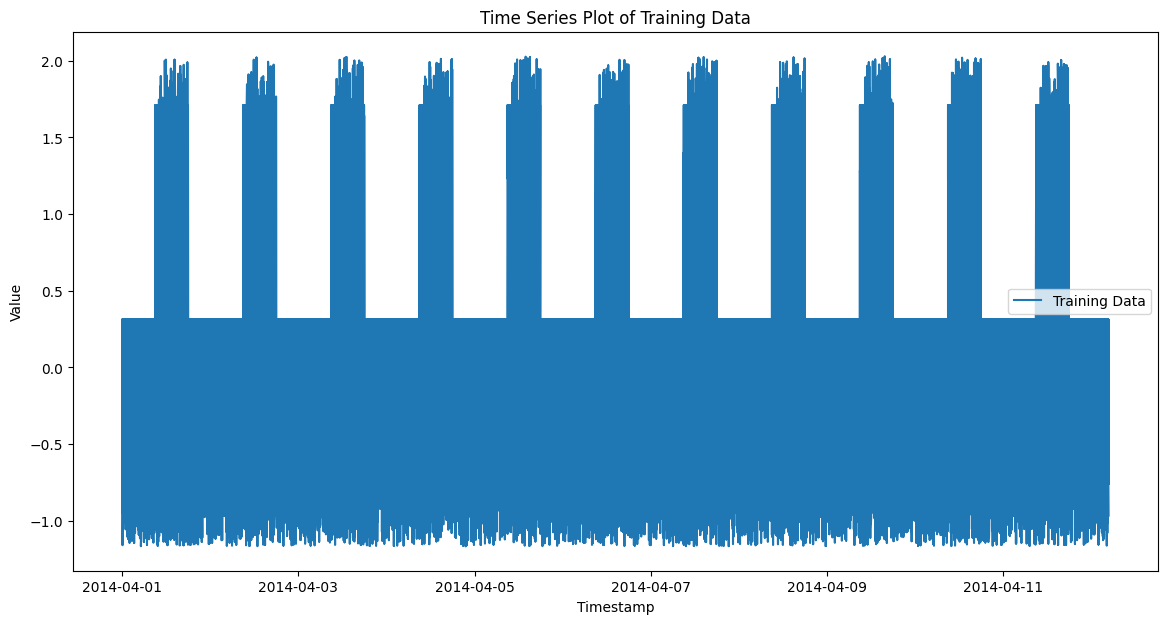

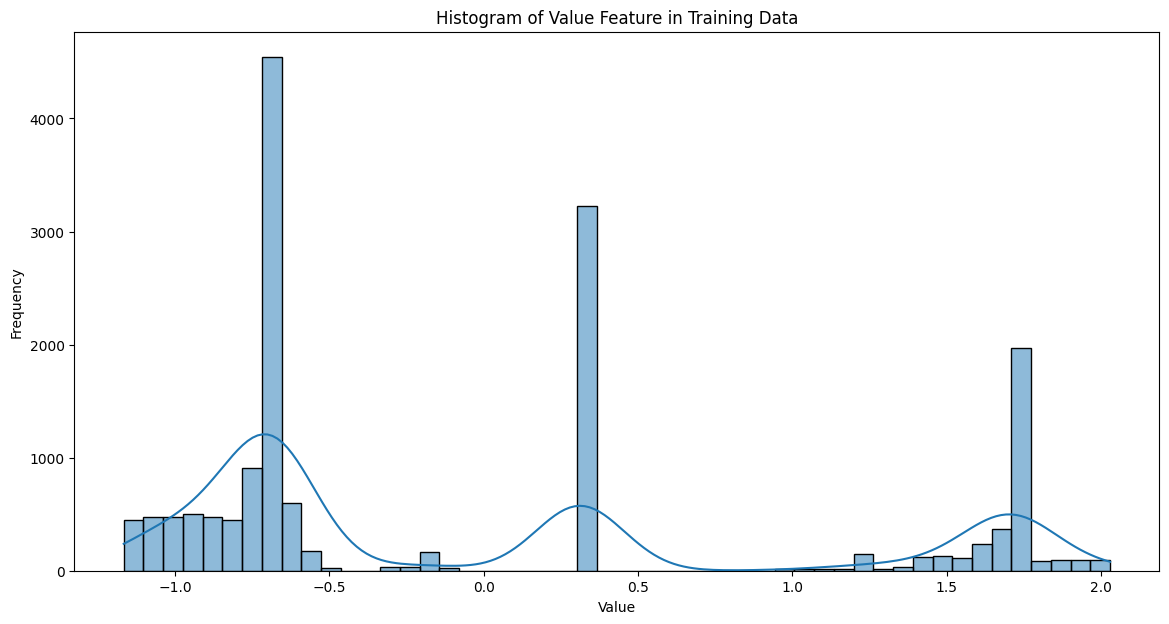

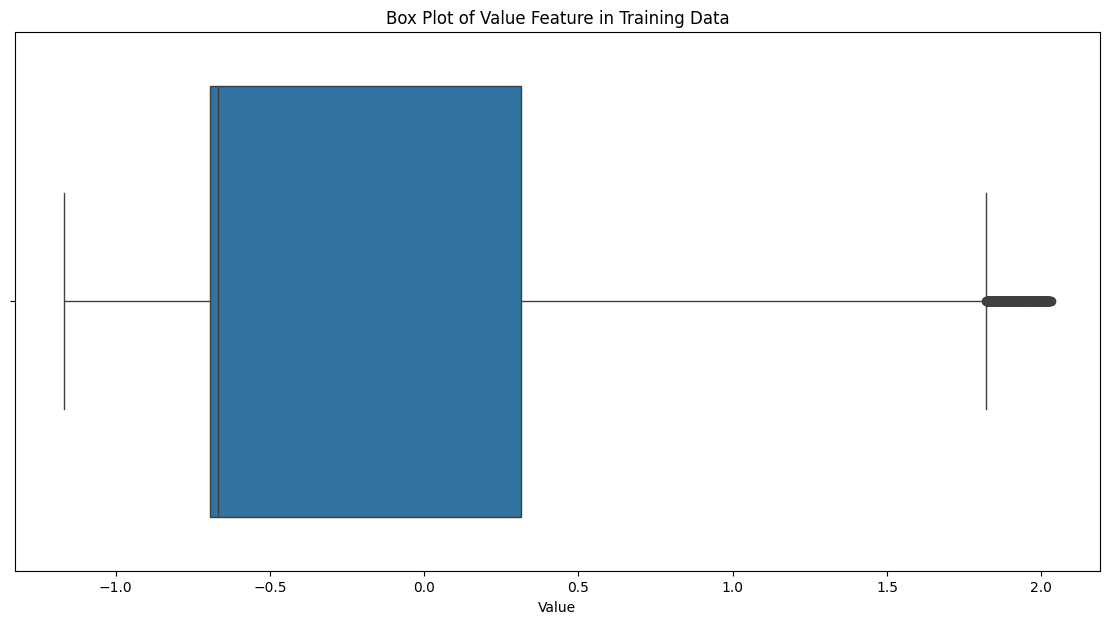

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# time series plot for Training Data
plt.figure(figsize=(14, 7))
plt.plot(train_data.index, train_data['value'], label='Training Data')
plt.title('Time Series Plot of Training Data')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()

# value histogram
plt.figure(figsize=(14, 7))
sns.histplot(train_data['value'], bins=50, kde=True)
plt.title('Histogram of Value Feature in Training Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

# value boxplot
plt.figure(figsize=(14, 7))
sns.boxplot(x=train_data['value'])
plt.title('Box Plot of Value Feature in Training Data')
plt.xlabel('Value')
plt.show()


LSTM Autoencoder

Epoch 1/20
504/504 [==============================] - 11s 11ms/step - loss: 0.6877 - val_loss: 0.6039
Epoch 2/20
504/504 [==============================] - 4s 8ms/step - loss: 0.5877 - val_loss: 0.5853
Epoch 3/20
504/504 [==============================] - 4s 8ms/step - loss: 0.5728 - val_loss: 0.5771
Epoch 4/20
504/504 [==============================] - 4s 9ms/step - loss: 0.5634 - val_loss: 0.5723
Epoch 5/20
504/504 [==============================] - 4s 8ms/step - loss: 0.5566 - val_loss: 0.5679
Epoch 6/20
504/504 [==============================] - 4s 8ms/step - loss: 0.5518 - val_loss: 0.5645
Epoch 7/20
504/504 [==============================] - 4s 8ms/step - loss: 0.5474 - val_loss: 0.5582
Epoch 8/20
504/504 [==============================] - 4s 8ms/step - loss: 0.5414 - val_loss: 0.5515
Epoch 9/20
504/504 [==============================] - 4s 9ms/step - loss: 0.5356 - val_loss: 0.5454
Epoch 10/20
504/504 [==============================] - 4s 8ms/step - loss: 0.5320 - val_loss: 0.54

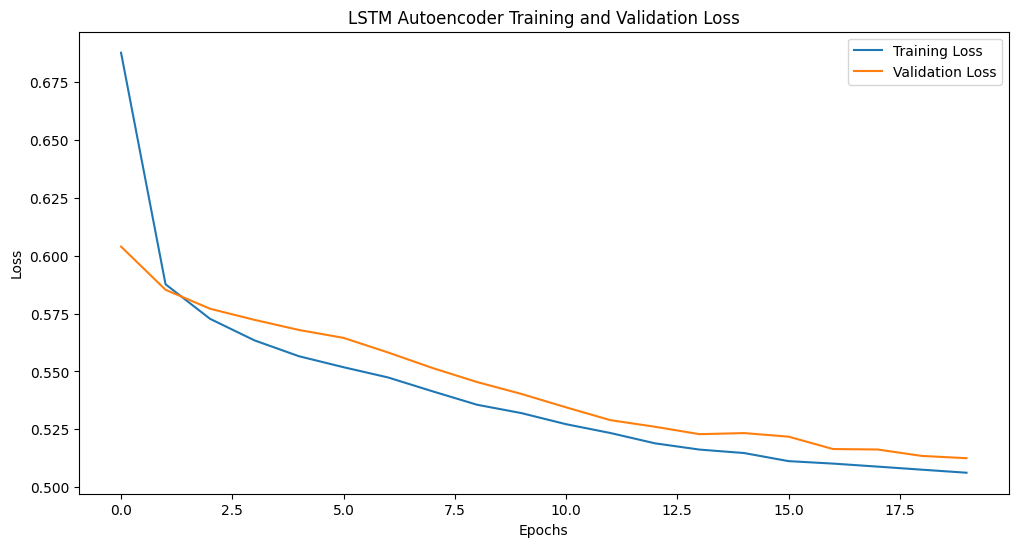

756/756 [==============================] - 3s 3ms/step - loss: 0.5447
Best F1 Score: 0.9790683471212037 at threshold 0.3020408163265306
Test Loss: 0.5446744561195374
Precision: 0.9589949967370024
Recall: 1.0
F1 Score: 0.9790683471212037
AUC Score: 0.9891909326275997


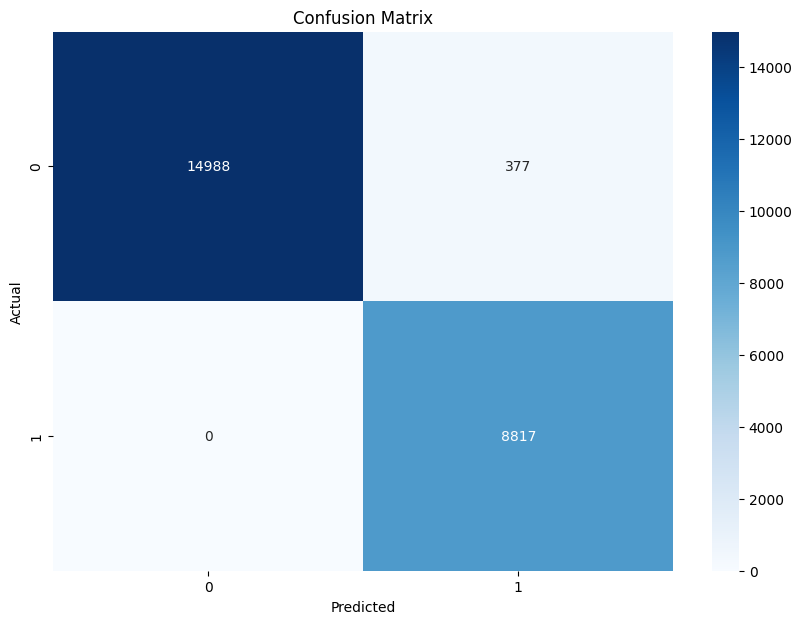

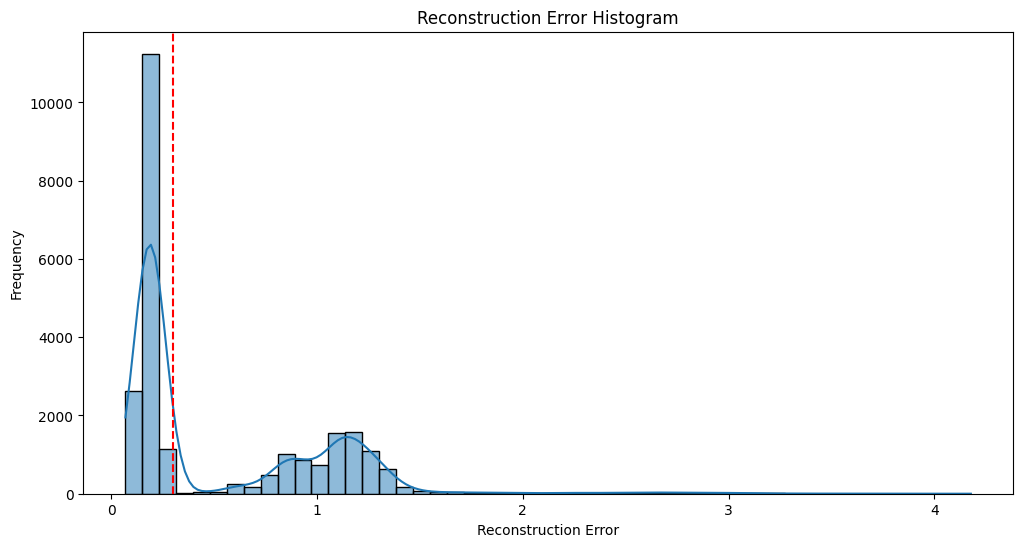

Training Loss: 0.48517754673957825
Validation Loss: 0.5125510096549988
Testing Loss: 0.5446744561195374


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score
import pickle

def lstm_autoencoder(timesteps, input_dim, learning_rate):
    input_layer = Input(shape=(timesteps, input_dim))

    encoder = LSTM(64, activation='tanh', recurrent_activation='sigmoid', return_sequences=True)(input_layer)
    encoder = Dropout(0.5)(encoder)
    encoder = LSTM(32, activation='tanh', recurrent_activation='sigmoid', return_sequences=False)(encoder)
    encoder = Dropout(0.5)(encoder)
    encoder = RepeatVector(timesteps)(encoder)

    decoder = LSTM(32, activation='tanh', recurrent_activation='sigmoid', return_sequences=True)(encoder)
    decoder = Dropout(0.5)(decoder)
    decoder = LSTM(64, activation='tanh', recurrent_activation='sigmoid', return_sequences=True)(decoder)
    decoder = Dropout(0.5)(decoder)
    output_layer = TimeDistributed(Dense(input_dim))(decoder)

    autoencoder = Model(inputs=input_layer, outputs=output_layer)

    optimizer = Adam(learning_rate=learning_rate)
    autoencoder.compile(optimizer=optimizer, loss='mse')
    return autoencoder

learning_rate = 0.0001

autoencoder = lstm_autoencoder(timesteps, input_dim, learning_rate)

early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

history = autoencoder.fit(
    train_data_reshaped, train_data_reshaped,
    epochs=20,
    batch_size=32,
    validation_data=(val_data_reshaped, val_data_reshaped),
    callbacks=[early_stopping]
)

#training/validation loss

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Autoencoder Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

with open('lstm_autoencoder_weights.pkl', 'wb') as f:
    pickle.dump(autoencoder.get_weights(), f)

# evaluate on test set
test_preds = autoencoder.predict(test_data_reshaped)
test_loss = autoencoder.evaluate(test_data_reshaped, test_data_reshaped)

# reconstruction error
reconstruction_error = np.mean(np.power(test_data_reshaped - test_preds, 2), axis=(1, 2))

# different thresholds
best_f1 = 0
best_threshold = 0
for threshold in np.linspace(0.1, 1, 50):
    predictions = (reconstruction_error > threshold).astype(int)
    actuals = (test_data_reshaped.mean(axis=(1, 2)) > threshold).astype(int)
    _, _, f1, _ = precision_recall_fscore_support(actuals, predictions, average='binary')
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f'Best F1 Score: {best_f1} at threshold {best_threshold}')

predictions = (reconstruction_error > best_threshold).astype(int)

actuals = (test_data_reshaped.mean(axis=(1, 2)) > best_threshold).astype(int)

# evaluate
precision, recall, f1, _ = precision_recall_fscore_support(actuals, predictions, average='binary')
auc_score = roc_auc_score(actuals, reconstruction_error)

print(f'Test Loss: {test_loss}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'AUC Score: {auc_score}')

# cm
conf_matrix = confusion_matrix(actuals, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# reconstruction error histogram
plt.figure(figsize=(12, 6))
sns.histplot(reconstruction_error, bins=50, kde=True)
plt.axvline(best_threshold, color='r', linestyle='--')
plt.title('Reconstruction Error Histogram')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.show()

train_loss = autoencoder.evaluate(train_data_reshaped, train_data_reshaped, verbose=0)
val_loss = autoencoder.evaluate(val_data_reshaped, val_data_reshaped, verbose=0)

print(f'Training Loss: {train_loss}')
print(f'Validation Loss: {val_loss}')
print(f'Testing Loss: {test_loss}')

Conv1D Model

Epoch 1/20
504/504 [==============================] - 4s 5ms/step - loss: 0.8941 - val_loss: 0.7316
Epoch 2/20
504/504 [==============================] - 3s 5ms/step - loss: 0.7142 - val_loss: 0.7280
Epoch 3/20
504/504 [==============================] - 3s 5ms/step - loss: 0.7088 - val_loss: 0.7210
Epoch 4/20
504/504 [==============================] - 3s 5ms/step - loss: 0.7037 - val_loss: 0.7133
Epoch 5/20
504/504 [==============================] - 3s 5ms/step - loss: 0.6965 - val_loss: 0.7025
Epoch 6/20
504/504 [==============================] - 3s 5ms/step - loss: 0.6900 - val_loss: 0.6958
Epoch 7/20
504/504 [==============================] - 3s 5ms/step - loss: 0.6853 - val_loss: 0.6905
Epoch 8/20
504/504 [==============================] - 2s 5ms/step - loss: 0.6817 - val_loss: 0.6874
Epoch 9/20
504/504 [==============================] - 3s 5ms/step - loss: 0.6789 - val_loss: 0.6853
Epoch 10/20
504/504 [==============================] - 2s 5ms/step - loss: 0.6765 - val_loss: 0.6833

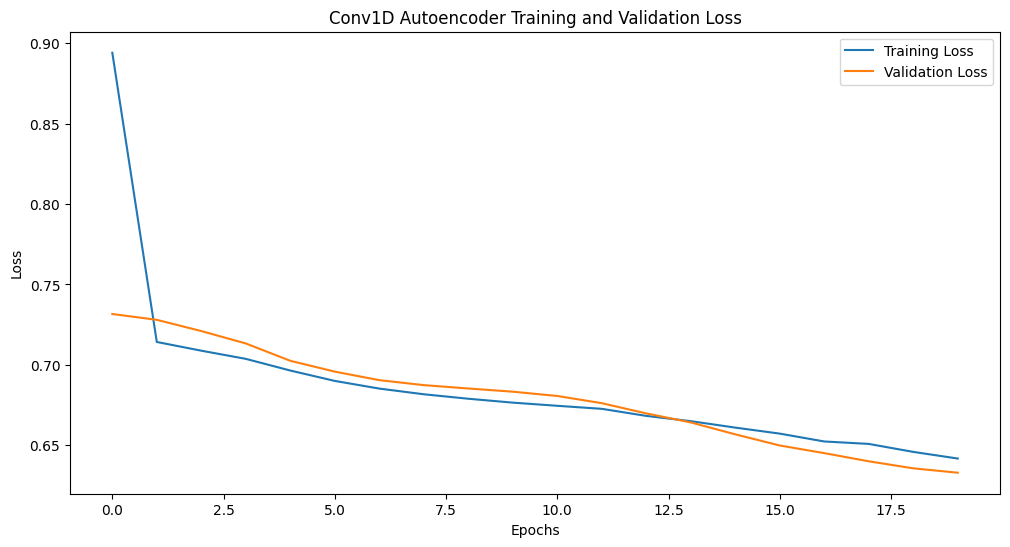

756/756 [==============================] - 2s 2ms/step - loss: 0.6361
Best F1 Score: 0.8516627078384797 at threshold 0.5959183673469388
Test Loss: 0.6360729932785034
Precision: 0.8041040592061001
Recall: 0.9052007068921989
F1 Score: 0.8516627078384797
AUC Score: 0.924532961752238


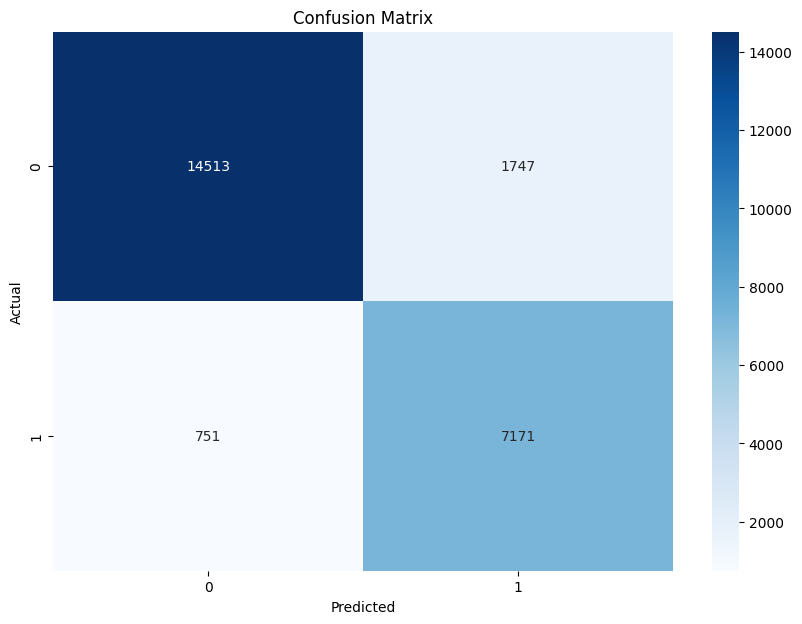

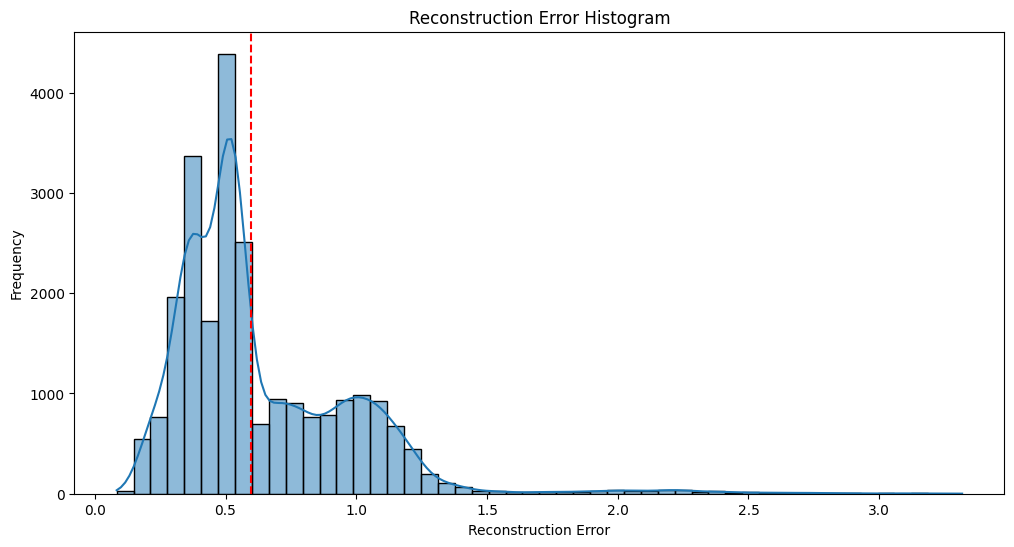

Training Loss: 0.6140931248664856
Validation Loss: 0.6329386234283447
Testing Loss: 0.6360729932785034


In [ ]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, Dropout, Cropping1D


def conv1d_autoencoder(timesteps, input_dim, learning_rate):
    input_layer = Input(shape=(timesteps, input_dim))

    encoder = Conv1D(64, kernel_size=3, activation='relu', padding='same')(input_layer)
    encoder = MaxPooling1D(pool_size=2, padding='same')(encoder)
    encoder = Dropout(0.5)(encoder)

    encoder = Conv1D(32, kernel_size=3, activation='relu', padding='same')(encoder)
    encoder = MaxPooling1D(pool_size=2, padding='same')(encoder)
    encoder = Dropout(0.5)(encoder)

    decoder = Conv1D(32, kernel_size=3, activation='relu', padding='same')(encoder)
    decoder = UpSampling1D(size=2)(decoder)
    decoder = Dropout(0.5)(decoder)

    decoder = Conv1D(64, kernel_size=3, activation='relu', padding='same')(decoder)
    decoder = UpSampling1D(size=2)(decoder)
    decoder = Dropout(0.5)(decoder)

    output_layer = Conv1D(input_dim, kernel_size=3, activation='sigmoid', padding='same')(decoder)
    if output_layer.shape[1] != timesteps:
        output_layer = Cropping1D(cropping=(0, output_layer.shape[1] - timesteps))(output_layer)

    autoencoder = Model(inputs=input_layer, outputs=output_layer)

    optimizer = Adam(learning_rate=learning_rate)
    autoencoder.compile(optimizer=optimizer, loss='mse')
    return autoencoder

learning_rate = 0.0001

autoencoder = conv1d_autoencoder(timesteps, input_dim, learning_rate)

early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

history = autoencoder.fit(
    train_data_reshaped, train_data_reshaped,
    epochs=20,
    batch_size=32,
    validation_data=(val_data_reshaped, val_data_reshaped),
    callbacks=[early_stopping]
)

# training/validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Conv1D Autoencoder Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

with open('conv1d_autoencoder_weights.pkl', 'wb') as f:
    pickle.dump(autoencoder.get_weights(), f)

# evaluate on test set
test_preds = autoencoder.predict(test_data_reshaped)
test_loss = autoencoder.evaluate(test_data_reshaped, test_data_reshaped)

# reconstruction error
reconstruction_error = np.mean(np.power(test_data_reshaped - test_preds, 2), axis=(1, 2))

# best threshold
best_f1 = 0
best_threshold = 0
for threshold in np.linspace(0.1, 1, 50):
    predictions = (reconstruction_error > threshold).astype(int)
    actuals = (test_data_reshaped.mean(axis=(1, 2)) > threshold).astype(int)
    _, _, f1, _ = precision_recall_fscore_support(actuals, predictions, average='binary')
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f'Best F1 Score: {best_f1} at threshold {best_threshold}')

predictions = (reconstruction_error > best_threshold).astype(int)
actuals = (test_data_reshaped.mean(axis=(1, 2)) > best_threshold).astype(int)

# evaluate
precision, recall, f1, _ = precision_recall_fscore_support(actuals, predictions, average='binary')
auc_score = roc_auc_score(actuals, reconstruction_error)

print(f'Test Loss: {test_loss}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'AUC Score: {auc_score}')

# cm
conf_matrix = confusion_matrix(actuals, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# reconstruction error histogram
plt.figure(figsize=(12, 6))
sns.histplot(reconstruction_error, bins=50, kde=True)
plt.axvline(best_threshold, color='r', linestyle='--')
plt.title('Reconstruction Error Histogram')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.show()

train_loss = autoencoder.evaluate(train_data_reshaped, train_data_reshaped, verbose=0)
val_loss = autoencoder.evaluate(val_data_reshaped, val_data_reshaped, verbose=0)

print(f'Training Loss: {train_loss}')
print(f'Validation Loss: {val_loss}')
print(f'Testing Loss: {test_loss}')


Dense Model


Epoch 1/20
504/504 [==============================] - 4s 4ms/step - loss: 1.1033 - val_loss: 0.8215
Epoch 2/20
504/504 [==============================] - 2s 4ms/step - loss: 0.8186 - val_loss: 0.7904
Epoch 3/20
504/504 [==============================] - 2s 4ms/step - loss: 0.7742 - val_loss: 0.7863
Epoch 4/20
504/504 [==============================] - 2s 4ms/step - loss: 0.7611 - val_loss: 0.7777
Epoch 5/20
504/504 [==============================] - 2s 4ms/step - loss: 0.7475 - val_loss: 0.7588
Epoch 6/20
504/504 [==============================] - 2s 4ms/step - loss: 0.7316 - val_loss: 0.7393
Epoch 7/20
504/504 [==============================] - 2s 4ms/step - loss: 0.7233 - val_loss: 0.7345
Epoch 8/20
504/504 [==============================] - 2s 4ms/step - loss: 0.7197 - val_loss: 0.7336
Epoch 9/20
504/504 [==============================] - 2s 4ms/step - loss: 0.7182 - val_loss: 0.7331
Epoch 10/20
504/504 [==============================] - 2s 4ms/step - loss: 0.7167 - val_loss: 0.7324

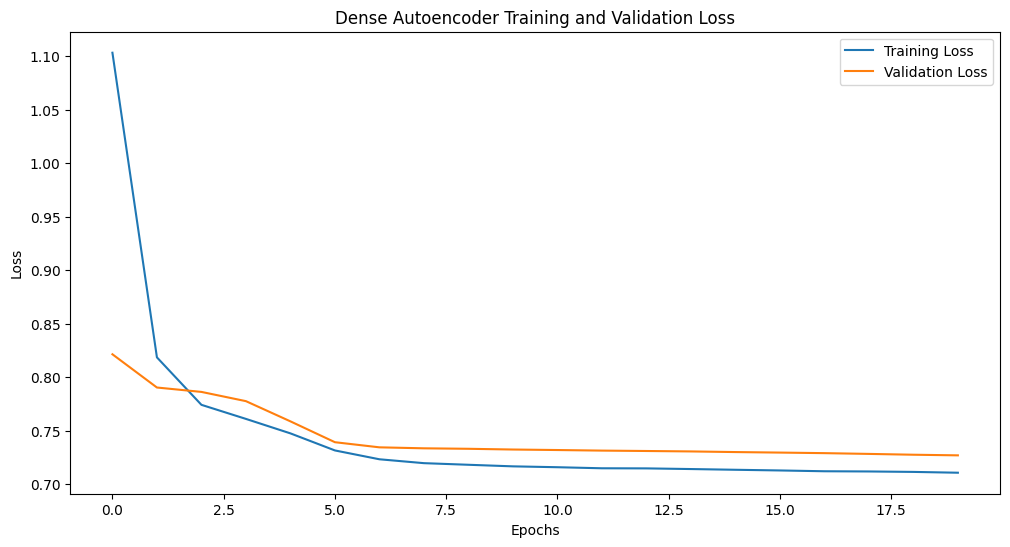

756/756 [==============================] - 1s 2ms/step - loss: 0.7495
Best F1 Score: 0.8933002481389578 at threshold 0.5959183673469388
Test Loss: 0.7494638562202454
Precision: 0.8073394495412844
Recall: 0.9997475385003787
F1 Score: 0.8933002481389578
AUC Score: 0.9563853661763075


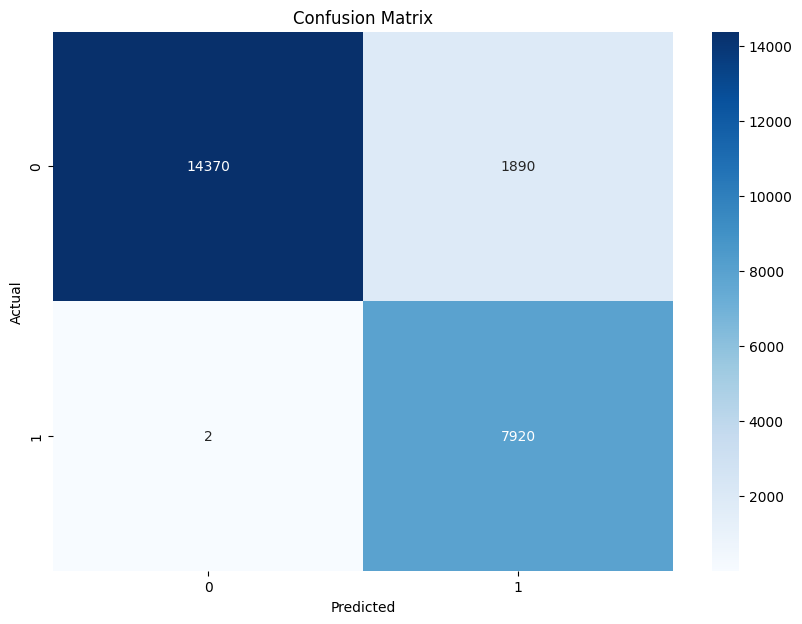

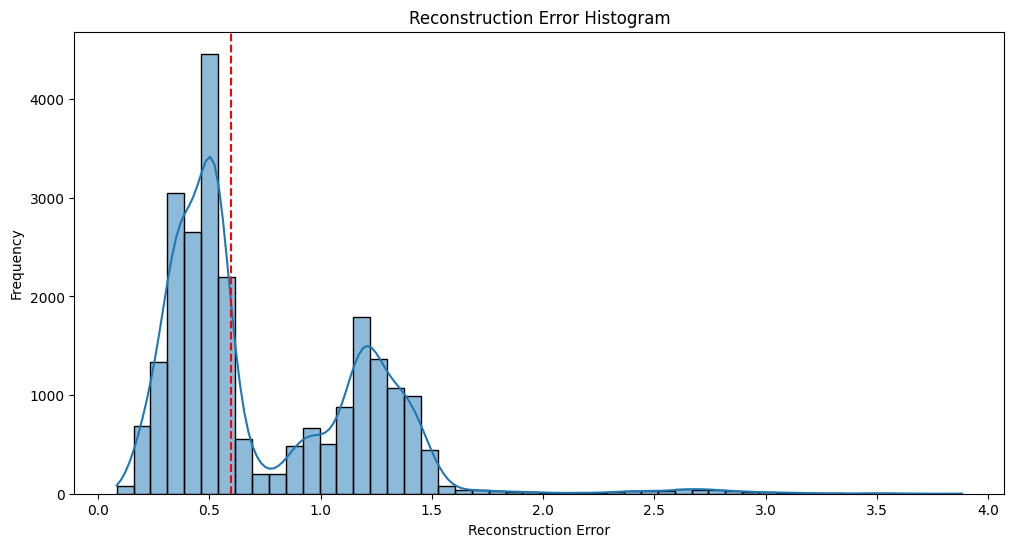

Training Loss: 0.706845760345459
Validation Loss: 0.7270006537437439
Testing Loss: 0.7494638562202454


In [ ]:
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Reshape


def dense_autoencoder(timesteps, input_dim, learning_rate):
    input_layer = Input(shape=(timesteps, input_dim))

    flat_input = Flatten()(input_layer)

    encoder = Dense(128, activation='relu')(flat_input)
    encoder = Dropout(0.5)(encoder)
    encoder = Dense(64, activation='relu')(encoder)
    encoder = Dropout(0.5)(encoder)
    encoder = Dense(32, activation='relu')(encoder)
    encoder = Dropout(0.5)(encoder)

    decoder = Dense(64, activation='relu')(encoder)
    decoder = Dropout(0.5)(decoder)
    decoder = Dense(128, activation='relu')(decoder)
    decoder = Dropout(0.5)(decoder)
    decoder = Dense(timesteps * input_dim, activation='sigmoid')(decoder)

    output_layer = Reshape((timesteps, input_dim))(decoder)

    autoencoder = Model(inputs=input_layer, outputs=output_layer)

    optimizer = Adam(learning_rate=learning_rate)
    autoencoder.compile(optimizer=optimizer, loss='mse')
    return autoencoder

learning_rate = 0.0001

autoencoder = dense_autoencoder(timesteps, input_dim, learning_rate)

early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

history = autoencoder.fit(
    train_data_reshaped, train_data_reshaped,
    epochs=20,
    batch_size=32,
    validation_data=(val_data_reshaped, val_data_reshaped),
    callbacks=[early_stopping]
)

# training/validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Dense Autoencoder Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

with open('dense_autoencoder_weights.pkl', 'wb') as f:
    pickle.dump(autoencoder.get_weights(), f)

# evaluate on test set
test_preds = autoencoder.predict(test_data_reshaped)
test_loss = autoencoder.evaluate(test_data_reshaped, test_data_reshaped)

# reconstruction error
reconstruction_error = np.mean(np.power(test_data_reshaped - test_preds, 2), axis=(1, 2))

# best threshold
best_f1 = 0
best_threshold = 0
for threshold in np.linspace(0.1, 1, 50):
    predictions = (reconstruction_error > threshold).astype(int)
    actuals = (test_data_reshaped.mean(axis=(1, 2)) > threshold).astype(int)
    _, _, f1, _ = precision_recall_fscore_support(actuals, predictions, average='binary')
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f'Best F1 Score: {best_f1} at threshold {best_threshold}')

predictions = (reconstruction_error > best_threshold).astype(int)
actuals = (test_data_reshaped.mean(axis=(1, 2)) > best_threshold).astype(int)

# evaluate
precision, recall, f1, _ = precision_recall_fscore_support(actuals, predictions, average='binary')
auc_score = roc_auc_score(actuals, reconstruction_error)

print(f'Test Loss: {test_loss}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'AUC Score: {auc_score}')

# cm
conf_matrix = confusion_matrix(actuals, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# reconstruction error histogram
plt.figure(figsize=(12, 6))
sns.histplot(reconstruction_error, bins=50, kde=True)
plt.axvline(best_threshold, color='r', linestyle='--')
plt.title('Reconstruction Error Histogram')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.show()

train_loss = autoencoder.evaluate(train_data_reshaped, train_data_reshaped, verbose=0)
val_loss = autoencoder.evaluate(val_data_reshaped, val_data_reshaped, verbose=0)

print(f'Training Loss: {train_loss}')
print(f'Validation Loss: {val_loss}')
print(f'Testing Loss: {test_loss}')
